In [7]:
from mysql.connector import Error
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Configura o notebook para exibir os gráficos na saída da célula
%matplotlib inline

In [ ]:
def conectar_mysql():
    """
    Função para conectar ao banco de dados MySQL.
    Retorna o objeto de conexão ou None se a conexão falhar.
    """
    try:
        host_db = "localhost"
        usuario_db = "root"
        senha_db = "senha123"  
        banco_de_dados = "ti_saude"

        conexao = mysql.connector.connect(
            host=host_db,
            user=usuario_db,
            password=senha_db,
            database=banco_de_dados
        )

        if conexao.is_connected():
            print("Conexão com o banco de dados MySQL bem-sucedida!")
            return conexao

    except Error as e:
        print(f"Erro ao conectar ao MySQL: {e}")
        return None

In [9]:
def automacao_ortopedia(conexao):
    """
    Executa a automação para a especialidade de Ortopedia.
    """
    if not conexao:
        print("Não foi possível realizar a automação por falta de conexão.")
        return
    try:
        query_ortopedia = """
        SELECT * FROM agendamentos
        WHERE especialidade = 'Ortopedia' AND status_agendamento = 'Realizado'
          AND data_agendamento >= DATE_SUB(CURDATE(), INTERVAL 30 DAY);
        """
        print("\nExecutando a consulta para Ortopedia...")
        df_ortopedia = pd.read_sql_query(query_ortopedia, conexao)

        if df_ortopedia.empty:
            print("Nenhum agendamento de Ortopedia encontrado nos últimos 30 dias.")
            return

        print(f"{len(df_ortopedia)} agendamentos de Ortopedia encontrados.")
        df_ortopedia['valor_consulta'] = pd.to_numeric(df_ortopedia['valor_consulta'])
        valor_medio = df_ortopedia['valor_consulta'].mean()

        nome_arquivo_csv = 'ortopedia_ultimos_30dias.csv'
        df_ortopedia.to_csv(nome_arquivo_csv, index=False, sep=';', decimal=',')
        
        print(f"Dados exportados com sucesso para o arquivo '{nome_arquivo_csv}'.")
        print(f"\nO valor médio das consultas de Ortopedia nos últimos 30 dias é: R$ {valor_medio:.2f}")

    except Error as e:
        print(f"Erro ao executar a consulta SQL: {e}")
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")

In [10]:
def criar_visualizacoes(conexao):
    """
    Cria e salva visualizações de dados a partir dos agendamentos.
    """
    if not conexao:
        print("Não foi possível criar visualizações por falta de conexão.")
        return

    print("\nIniciando a criação de visualizações...")
    try:
        # Carrega todos os dados da tabela para um DataFrame para análise
        query_total = "SELECT * FROM agendamentos;"
        df_total = pd.read_sql_query(query_total, conexao, parse_dates=['data_agendamento'])
        
        # Define um estilo estético para os gráficos
        sns.set_style("whitegrid")

        # --- Gráfico 1: Receita por Especialidade ---
        print("Gerando Gráfico 1: Receita por Especialidade...")
        df_receita = df_total[df_total['status_agendamento'].isin(['Realizado', 'Confirmado'])].copy()
        df_receita['valor_consulta'] = pd.to_numeric(df_receita['valor_consulta'])
        receita_por_especialidade = df_receita.groupby('especialidade')['valor_consulta'].sum().sort_values(ascending=False)

        plt.figure(figsize=(12, 7)) # Define o tamanho da figura
        ax1 = sns.barplot(x=receita_por_especialidade.index, y=receita_por_especialidade.values, palette="viridis")
        ax1.set_title('Receita Total por Especialidade (Realizados + Confirmados)', fontsize=16)
        ax1.set_xlabel('Especialidade', fontsize=12)
        ax1.set_ylabel('Receita Total (R$)', fontsize=12)
        plt.xticks(rotation=45, ha='right') # Rotaciona os nomes das especialidades
        plt.tight_layout() # Ajusta o layout para evitar sobreposição
        plt.savefig('receita_por_especialidade.png') # Salva o gráfico
        print("Gráfico 'receita_por_especialidade.png' salvo com sucesso.")
        plt.show() # Mostra o gráfico no notebook
        plt.close()

        # --- Gráfico 2: Distribuição de Status dos Agendamentos ---
        print("\nGerando Gráfico 2: Distribuição de Status dos Agendamentos...")
        plt.figure(figsize=(10, 6))
        ax2 = sns.countplot(x='status_agendamento', data=df_total, palette="plasma", order=df_total['status_agendamento'].value_counts().index)
        ax2.set_title('Distribuição de Status dos Agendamentos', fontsize=16)
        ax2.set_xlabel('Status do Agendamento', fontsize=12)
        ax2.set_ylabel('Quantidade', fontsize=12)
        plt.tight_layout()
        plt.savefig('distribuicao_status_agendamentos.png')
        print("Gráfico 'distribuicao_status_agendamentos.png' salvo com sucesso.")
        plt.show() # Mostra o gráfico no notebook
        plt.close()

        # --- Gráfico 3: Tendência de Agendamentos Realizados por Mês ---
        print("\nGerando Gráfico 3: Tendência de Agendamentos Realizados por Mês...")
        df_realizados = df_total[df_total['status_agendamento'] == 'Realizado'].copy()
        # Cria uma coluna 'mes_ano' para agrupar
        df_realizados['mes_ano'] = df_realizados['data_agendamento'].dt.to_period('M')
        agendamentos_por_mes = df_realizados.groupby('mes_ano').size()
        agendamentos_por_mes.index = agendamentos_por_mes.index.to_timestamp() # Converte para o gráfico

        plt.figure(figsize=(12, 6))
        ax3 = sns.lineplot(x=agendamentos_por_mes.index, y=agendamentos_por_mes.values, marker='o', color='royalblue')
        ax3.set_title('Tendência de Agendamentos Realizados por Mês', fontsize=16)
        ax3.set_xlabel('Mês', fontsize=12)
        ax3.set_ylabel('Número de Agendamentos Realizados', fontsize=12)
        plt.tight_layout()
        plt.savefig('tendencia_agendamentos_mensal.png')
        print("Gráfico 'tendencia_agendamentos_mensal.png' salvo com sucesso.")
        plt.show() # Mostra o gráfico no notebook
        plt.close()

    except Exception as e:
        print(f"Ocorreu um erro ao gerar as visualizações: {e}")

Conexão com o banco de dados MySQL bem-sucedida!

Executando a consulta para Ortopedia...
173 agendamentos de Ortopedia encontrados.
Dados exportados com sucesso para o arquivo 'ortopedia_ultimos_30dias.csv'.

O valor médio das consultas de Ortopedia nos últimos 30 dias é: R$ 152.77

Iniciando a criação de visualizações...
Gerando Gráfico 1: Receita por Especialidade...


C:\Users\User\AppData\Local\Temp\ipykernel_3960\871992214.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ortopedia = pd.read_sql_query(query_ortopedia, conexao)
C:\Users\User\AppData\Local\Temp\ipykernel_3960\13828043.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_total = pd.read_sql_query(query_total, conexao, parse_dates=['data_agendamento'])
C:\Users\User\AppData\Local\Temp\ipykernel_3960\13828043.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=receita_por_especialidade.index, y=receita_por_espec

Gráfico 'receita_por_especialidade.png' salvo com sucesso.


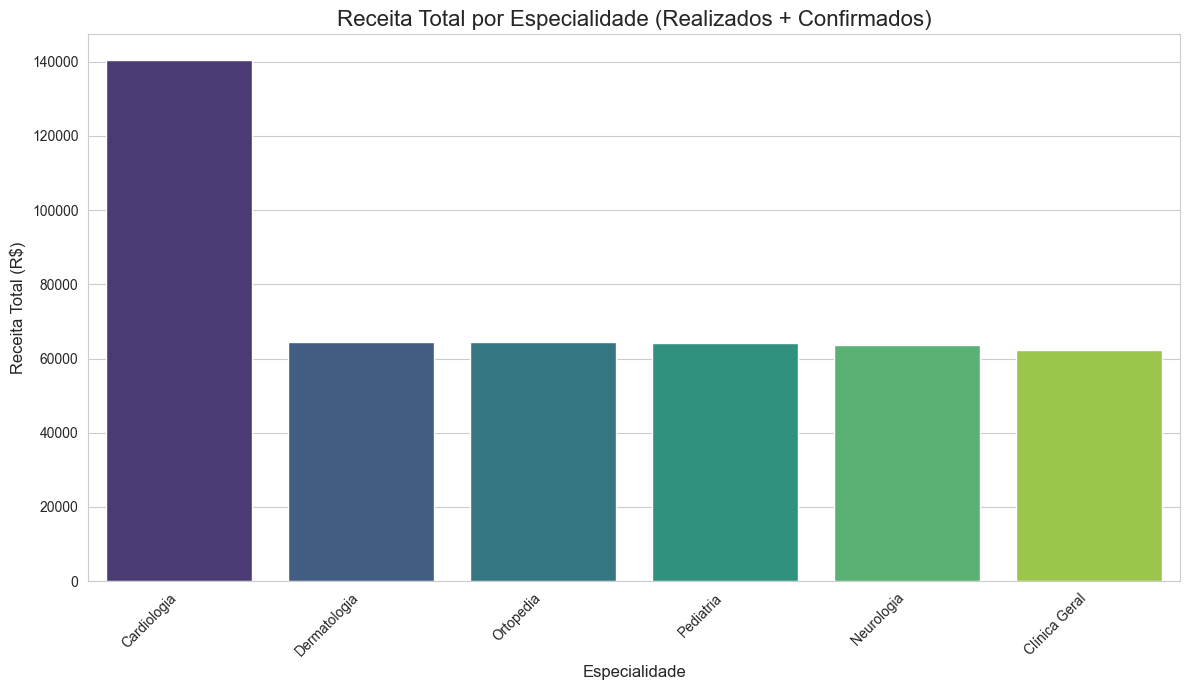


Gerando Gráfico 2: Distribuição de Status dos Agendamentos...
Gráfico 'distribuicao_status_agendamentos.png' salvo com sucesso.


C:\Users\User\AppData\Local\Temp\ipykernel_3960\13828043.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(x='status_agendamento', data=df_total, palette="plasma", order=df_total['status_agendamento'].value_counts().index)


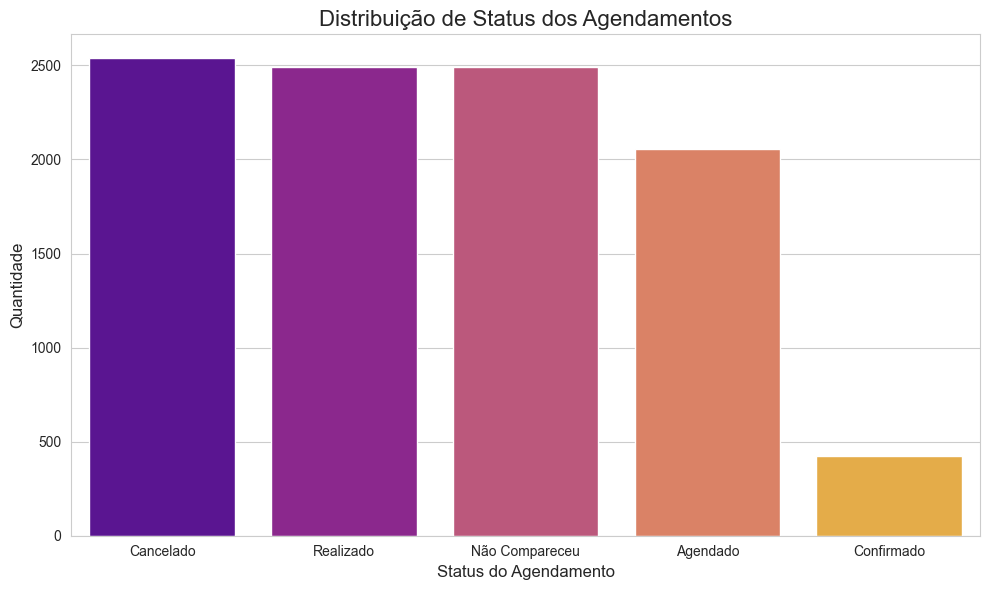


Gerando Gráfico 3: Tendência de Agendamentos Realizados por Mês...
Gráfico 'tendencia_agendamentos_mensal.png' salvo com sucesso.


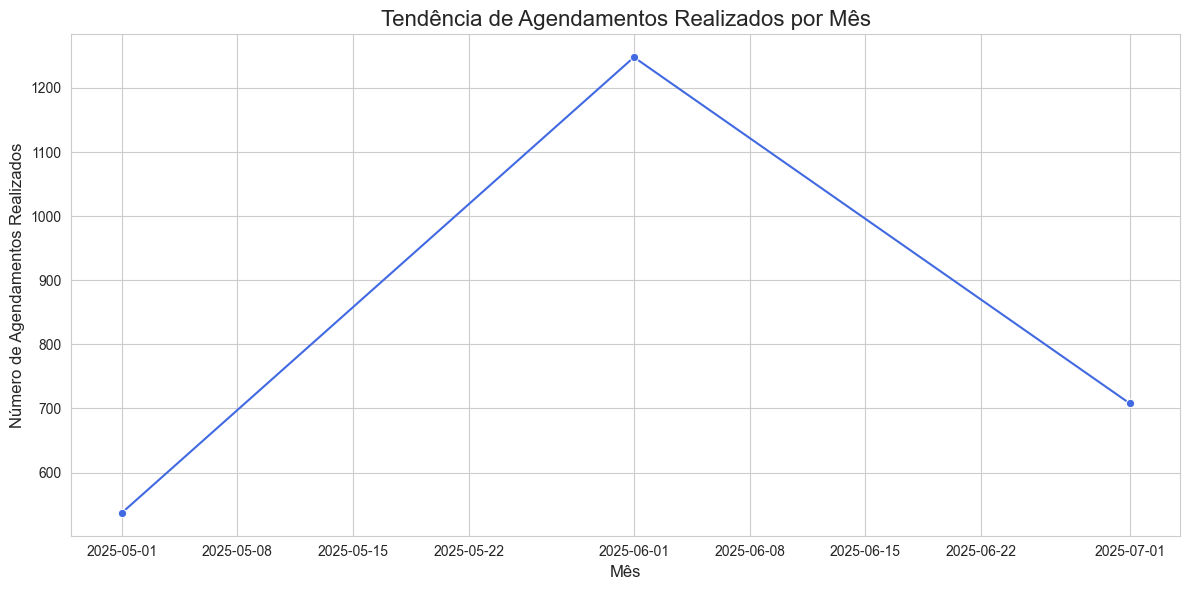


Conexão com o MySQL foi fechada.


In [11]:
# Ponto de entrada principal do script 

# Tenta estabelecer a conexão com o banco de dados
conn = conectar_mysql()

# Se a conexão for bem-sucedida, executa as funções
if conn and conn.is_connected():
    try:
        # Executa a função de automação para Ortopedia
        automacao_ortopedia(conn)

        # Executa a nova função para criar os gráficos
        criar_visualizacoes(conn)

    finally:
        # 3. Garante que a conexão com o banco seja fechada ao final
        conn.close()
        print("\nConexão com o MySQL foi fechada.")
else:
    print("\nA execução foi interrompida devido à falha na conexão com o banco de dados.")